# Parameterized transformer networks

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (10, 10)

In [39]:
# grid of parameter values for training
mus = [-2, 0, 2]
sigmas = [0.5, 1.0, 1.5]
n_params = 2

from itertools import product
p = list(product(mus, sigmas))
mus = [mu for mu, _ in p]
sigmas = [sigma for _, sigma in p]

print(mus, sigmas)

[-2, -2, -2, 0, 0, 0, 2, 2, 2] [0.5, 1.0, 1.5, 0.5, 1.0, 1.5, 0.5, 1.0, 1.5]


In [40]:
from carl.distributions import Normal
import theano

mu = theano.shared(0.0)
sigma = theano.shared(1.0)
p0 = Normal(mu=mu, sigma=sigma)  # target|mu,sigma

X0 = []

for m, s in zip(mus, sigmas):
    mu.set_value(m)
    sigma.set_value(s)   
    X0.append(p0.rvs(5000))
    
p1 = Normal(mu=0, sigma=1.0)  # source
X1 = [p1.rvs(5000) for i in range(len(X0))]

/home/gilles/src/carl/carl/distributions/base.py:128: UserWarning: The Param class is deprecated. Replace Param(default=N) by theano.In(value=N)
  [theano.Param(v, name=v.name) for v in args] +


In [41]:
import keras.backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Merge, Reshape
from keras.layers.advanced_activations import LeakyReLU

# D
D = Sequential()
D.add(Dense(12, input_dim=X0[0].shape[1] + n_params, activation=LeakyReLU()))
D.add(Dense(12, input_dim=12, activation=LeakyReLU()))
D.add(Dense(12, input_dim=12, activation=LeakyReLU()))
D.add(Dense(12, input_dim=12, activation=LeakyReLU()))
D.add(Dense(1, input_dim=12, activation='sigmoid'))

def loss_D(y_true, y_pred):
    return -((1.0 - y_true) * (K.log(1.0 - y_pred)) + 
             (y_true) * (K.log(y_pred)))  

# G
G = Sequential()
G.add(Dense(12, input_dim=X1[0].shape[1] + n_params, activation=LeakyReLU()))
G.add(Dense(12, input_dim=12, activation=LeakyReLU()))
G.add(Dense(12, input_dim=12, activation=LeakyReLU()))
G.add(Dense(12, input_dim=12, activation=LeakyReLU()))
G.add(Dense(X0[0].shape[1], input_dim=12, activation='linear'))
G.compile(loss="mse", optimizer="sgd")  

identity = Sequential()
identity.add(Reshape(input_shape=(n_params,), dims=(n_params,)))
identity.trainable = False

GD = Sequential()  
GD.add(Merge([G, identity], mode="concat"))   # need to pass params, otherwise X0 is seen as the mixture
D.trainable = False
GD.add(D)

def loss_GD(y_true, y_pred):
    return y_true * (K.log(y_pred))

# Compile
D.compile(loss=loss_D, optimizer="sgd")
GD.compile(loss=loss_GD, optimizer="sgd")

In [55]:
def plot_distribution(G, mu, sigma, X1):
    plt.hist(X1, bins=100, range=(-5, 5), alpha=0.5, 
             label="x~p1", normed=1, histtype="step")
    
    params = np.zeros((len(X1), n_params))
    params[:, 0] = mu
    params[:, 1] = sigma
    X = np.hstack((X1, params))
    Xt = G.predict(X)
    plt.hist(Xt, bins=100, range=(-5, 5), alpha=0.5, 
             label="G(x;mu=%.2f, sigma=%.2f), x~p1" % (mu, sigma), 
             normed=1, histtype="step")
    
    plt.text(-4.5, 0.9, "mu=%.2f, sigma=%.2f" % (np.mean(Xt), np.std(Xt)))

    plt.xlim(-5, 5)
    plt.ylim(0, 1)
    plt.legend(loc="best")
    plt.show()

In [61]:
batch_size = 16

y_D = np.zeros(batch_size)
y_D[batch_size // 2:] = 1
y_GD = np.ones(batch_size)

params = np.zeros((batch_size, n_params))

for i in range(10000):
    if i % 250 == 0: print(i)
        
    # XXX: optimize all parameters jointly instead of sequentially
        
    for j, (mu, sigma) in enumerate(zip(mus, sigmas)):
        params[:, 0] = mu
        params[:, 1] = sigma
        
        # fit D 
        indices0 = np.random.permutation(len(X0[j]))
        indices1 = np.random.permutation(len(X1[j]))
        X = np.vstack((X0[j][indices0[:batch_size // 2]],
                       G.predict(np.hstack((X1[j][indices1[:batch_size // 2]],
                                            params[:batch_size // 2])))))
        X = np.hstack((X, params))
        D.fit(X, y_D, nb_epoch=3, verbose=0)

        # fit GD   
        indices1 = np.random.permutation(len(X1[j]))
        X = X1[j][indices1[:batch_size]]       
        GD.fit([np.hstack((X, params)), params], y_GD, nb_epoch=1, verbose=0)

0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5250
5500
5750
6000
6250
6500
6750
7000
7250
7500
7750
8000
8250
8500
8750
9000
9250
9500
9750


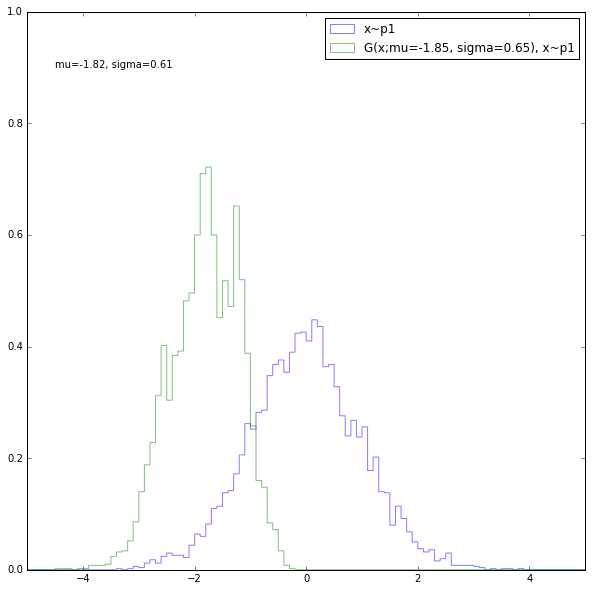

In [62]:
from ipywidgets import interact, FloatSlider

def plot(mu, sigma):
    plot_distribution(G, mu, sigma, X1[0])
    
interact(plot, mu=FloatSlider(value=0.0, min=-2, max=2, step=0.05),
         sigma=FloatSlider(value=1.0, min=0.5, max=1.5, step=0.05))